# Part I - Flight Delays Exploration
## by Julia Kinday

## Introduction

Original dataset consists of 22 separate CSV files with US domestic flight data from 1987 to 2008 year. Since the total amount of rows exceeds 120M I've decided to collect samples of 1000 rows for each year and combine them into one dataset. I used conditional sampling to get rows where Departure Delay is both non-NaN and greater than 0 because it is the primary feature I want to investigate. Columns provide information about flight's date, carrier, aircraft, several types of arriving and departing times, also about cancellations, divertions, delays and their reasons.
  
## Preliminary Wrangling

In [3]:
# Import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline
# Force plots to be rendered in HiDPI resolution
# Remove if causes issues on non-HiDPI screen
%config InlineBackend.figure_format = 'retina'

In [4]:
# Load the dataset
flights = pd.read_csv('combined.csv', index_col=0)
flights.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,1987,11,28,6,2042.0,2025,2105.0,2053,PI,801,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,1987,10,22,4,1805.0,1800,1933.0,1905,HP,226,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,1987,11,19,4,657.0,655,821.0,804,PI,79,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,1987,11,23,1,1848.0,1835,1944.0,1920,DL,653,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,1987,11,25,3,703.0,655,828.0,821,AA,2277,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN


In [5]:
# Look at the datasets structure, data types and missing values
flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22000 entries, 0 to 21999
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               22000 non-null  int64  
 1   Month              22000 non-null  int64  
 2   DayofMonth         22000 non-null  int64  
 3   DayOfWeek          22000 non-null  int64  
 4   DepTime            22000 non-null  float64
 5   CRSDepTime         22000 non-null  int64  
 6   ArrTime            21919 non-null  float64
 7   CRSArrTime         22000 non-null  int64  
 8   UniqueCarrier      22000 non-null  object 
 9   FlightNum          22000 non-null  int64  
 10  TailNum            14000 non-null  object 
 11  ActualElapsedTime  21917 non-null  float64
 12  CRSElapsedTime     22000 non-null  float64
 13  AirTime            13950 non-null  float64
 14  ArrDelay           21917 non-null  float64
 15  DepDelay           22000 non-null  float64
 16  Origin             220

### The main feature of interest

In this project I will focus on departure delays and what kind of features may affect it occurrence and duration.

### Secondary features

I'm planning to look into relationships between date and delays, what kind of reasons for delay exist and their effect on its duration, airports of origin and destination.

### Cleaning the data according exploration needs

In [6]:
# Drop 12 columns
to_drop = ['DepTime', 'ArrTime', 'CRSArrTime','CRSDepTime', 'FlightNum', 'TailNum','CRSElapsedTime', 'ActualElapsedTime', 'AirTime',
           'AirTime', 'Distance', 'TaxiIn', 'TaxiOut', 'Cancelled', 'CancellationCode', 'Diverted']

flights = flights.drop(to_drop, axis=1)

In [7]:
# Check if there is more than one reason for a delay for every particular flight
limit = 0
for index, flight in flights.iterrows():
    if limit >= 15:
        break
    count = 0
    if flight.CarrierDelay > 0:
        count += 1
    if flight.WeatherDelay > 0:
        count += 1
    if flight.NASDelay > 0:
        count += 1
    if flight.SecurityDelay > 0:
        count += 1
    if flight.LateAircraftDelay > 0:
        count += 1
    if count > 1:
        limit += 1
        with pd.option_context('max_colwidth', 150):
            print(index, flight.DepDelay, flight.ArrDelay, [flight.CarrierDelay, flight.WeatherDelay,
                                           flight.NASDelay, flight.SecurityDelay, flight.LateAircraftDelay])

16003 12.0 16.0 [0.0, 0.0, 5.0, 0.0, 11.0]
16008 29.0 36.0 [0.0, 0.0, 9.0, 0.0, 27.0]
16012 15.0 30.0 [7.0, 0.0, 15.0, 0.0, 8.0]
16014 74.0 394.0 [0.0, 74.0, 320.0, 0.0, 0.0]
16015 12.0 17.0 [8.0, 0.0, 5.0, 0.0, 4.0]
16018 53.0 44.0 [0.0, 5.0, 0.0, 0.0, 39.0]
16019 10.0 21.0 [11.0, 0.0, 10.0, 0.0, 0.0]
16022 43.0 45.0 [0.0, 0.0, 2.0, 0.0, 43.0]
16024 5.0 18.0 [0.0, 0.0, 13.0, 0.0, 5.0]
16029 16.0 17.0 [6.0, 0.0, 1.0, 0.0, 10.0]
16042 25.0 25.0 [13.0, 0.0, 0.0, 0.0, 12.0]
16043 15.0 32.0 [15.0, 0.0, 17.0, 0.0, 0.0]
16046 12.0 16.0 [12.0, 0.0, 4.0, 0.0, 0.0]
16049 22.0 19.0 [3.0, 0.0, 0.0, 0.0, 16.0]
16054 91.0 100.0 [0.0, 91.0, 9.0, 0.0, 0.0]


5 columns with delay reasons can't be melted into one column because one flight can have more than one delay reason and total departure/arriving delay time is counted by adding minutes of delay for part or all reasons. The delay calculation formula is unclear.

## Univariate Exploration

#### Departure Delay 
Let's look into the primary feature of interest.

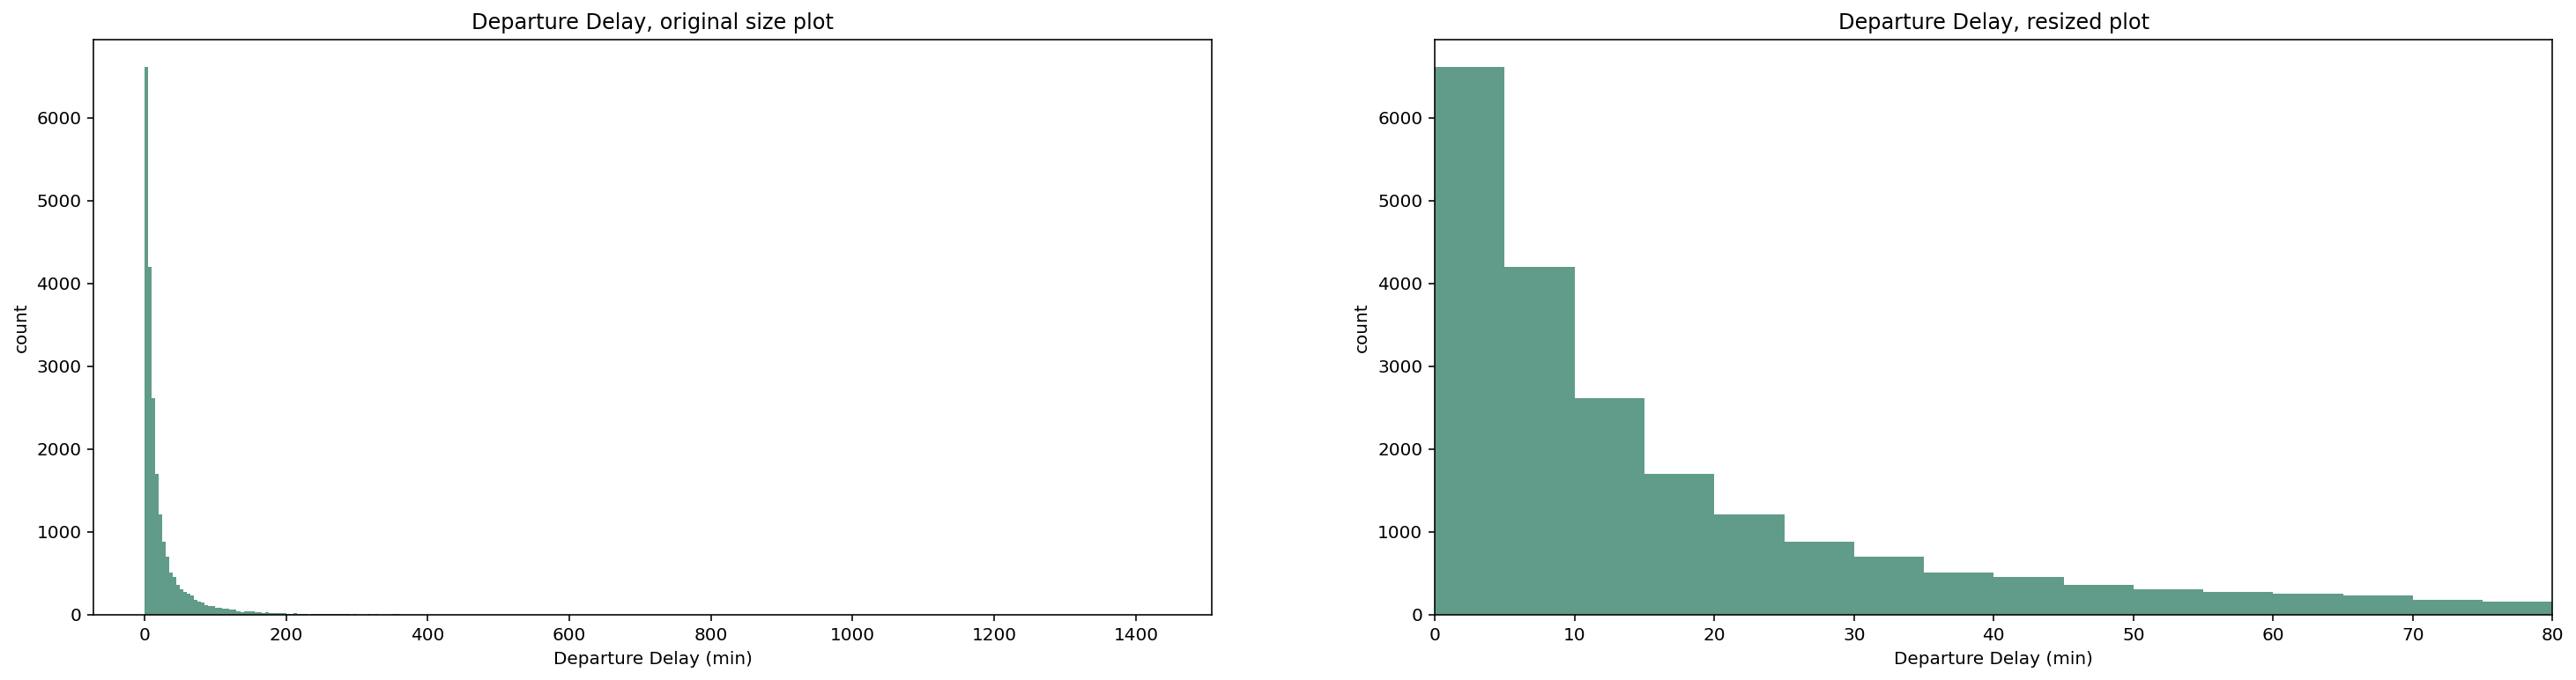

In [8]:
# Define basic color for exploration plots
color = '#619b8a'

# Plot DepDelay
binsize = 5
bins = np.arange(0, flights['DepDelay'].max()+binsize, binsize)

plt.figure(figsize = [25, 6])

# standart plot
plt.subplot(1, 2, 1) 
plt.hist(data = flights, x='DepDelay', bins=bins, color=color)
plt.xlabel('Departure Delay (min)')
plt.ylabel('count')
plt.title('Departure Delay, original size plot')

# resized plot
plt.subplot(1, 2, 2)
plt.hist(data = flights, x = 'DepDelay', bins=bins, color=color)
plt.xlabel('Departure Delay (min)')
plt.ylabel('count')
plt.xlim((0,80))
plt.title('Departure Delay, resized plot');
plt.show()

Upper margin for outliers: 56.5
Amount of outliers: 2360
8353     1433.0
11640     793.0
17038     689.0
20920     619.0
17731     590.0
19746     564.0
21290     552.0
11351     549.0
20120     523.0
2532      496.0
3060      473.0
15740     431.0
19161     406.0
18399     380.0
12701     374.0
Name: DepDelay, dtype: float64


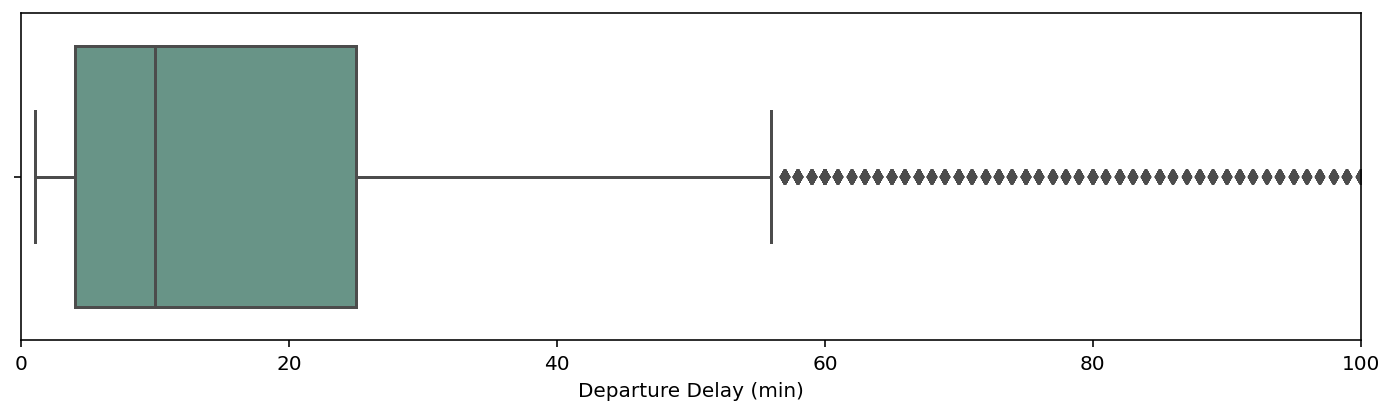

In [9]:
# Determine outliers by IQR, using box plot and visually

Q1 = flights.DepDelay.quantile(0.25)
Q3 = flights.DepDelay.quantile(0.75)
IQR = Q3 - Q1
margin = IQR * 1.5 + Q3
print('Upper margin for outliers: ' + str(margin))

count = flights[flights['DepDelay'] > margin].Month.count()
print('Amount of outliers: ' + str(count))

plt.figure(figsize = [12, 3])
sb.boxplot(x=flights['DepDelay'], color=color)
plt.xlabel('Departure Delay (min)')
plt.xlim((0,100));

print(flights.DepDelay.sort_values(ascending=False)[:15])

There is a long tail and many outliers on the long-delays end, so I'm going to look at it on a log scale.

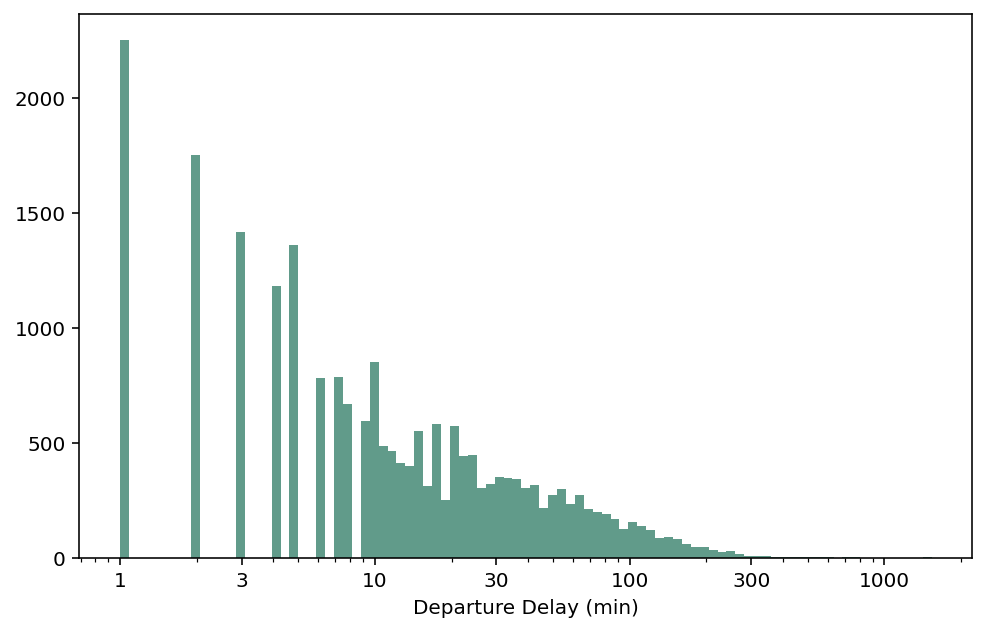

In [10]:
# Log scale distribution 

log_binsize = 0.035
bins = 10 ** np.arange(0, np.log10(flights['DepDelay'].max())+log_binsize, log_binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = flights, x = 'DepDelay', bins = bins, color=color)
plt.xscale('log')
plt.xticks([1, 3, 10, 30, 100, 300, 1000], [1, 3, 10, 30, 100, 300, 1000])
plt.xlabel('Departure Delay (min)')
plt.show()

The delay distribution looks unimodal, right skewed when plotted on a log-scale, with most delays within 1-60 minutes.

In [11]:
# Remove extreme outliers 
Q1 = flights.DepDelay.quantile(0.25)
Q3 = flights.DepDelay.quantile(0.75)
IQR = Q3 - Q1
extr_margin = IQR * 3 + Q3
print('Upper margin for outliers: ' + str(extr_margin))

flights = flights[flights['DepDelay'] < extr_margin]
flights.shape

Upper margin for outliers: 88.0


(20811, 14)

#### Dates exploration
Are there any abnormalities in month, day, day of week distributions? 

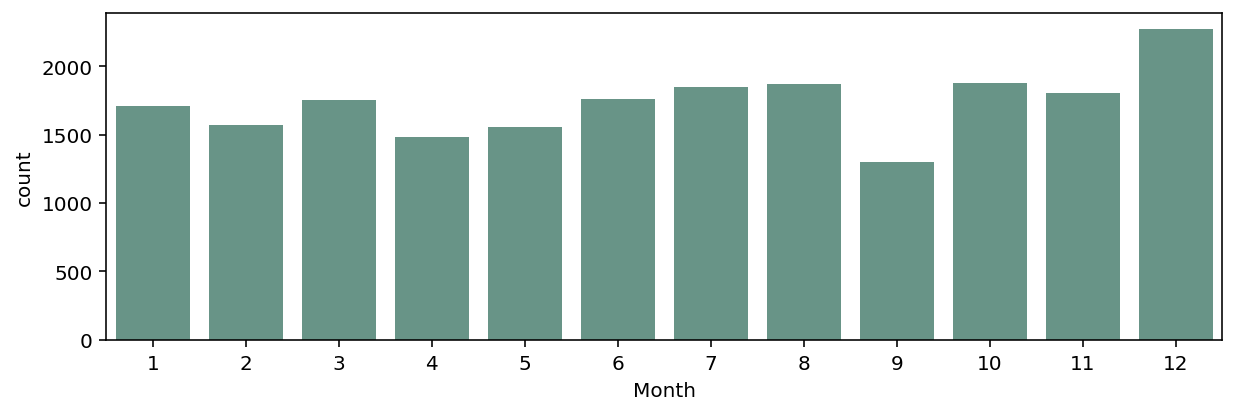

In [12]:
plt.figure(figsize = [10, 3])
sb.countplot(data=flights, x='Month', color=color);

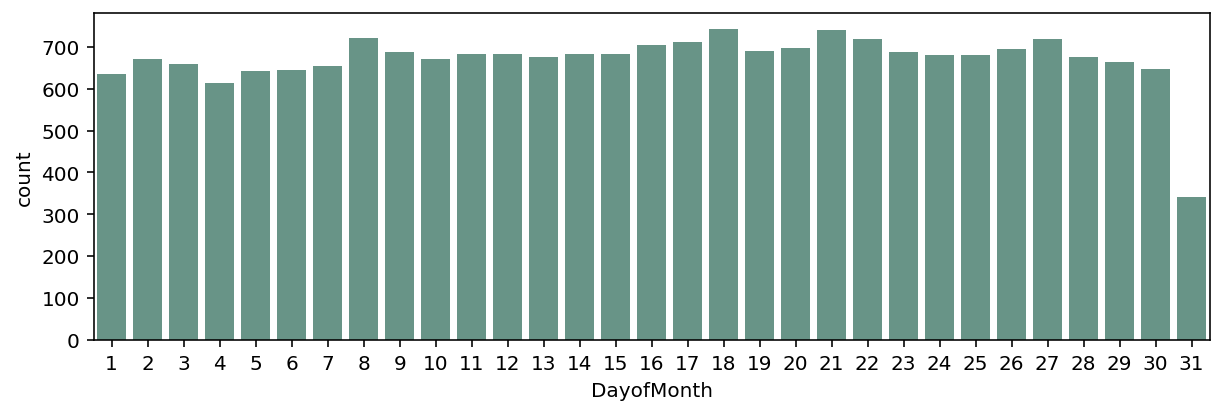

In [13]:
plt.figure(figsize = [10, 3])
sb.countplot(data=flights, x='DayofMonth', color=color);

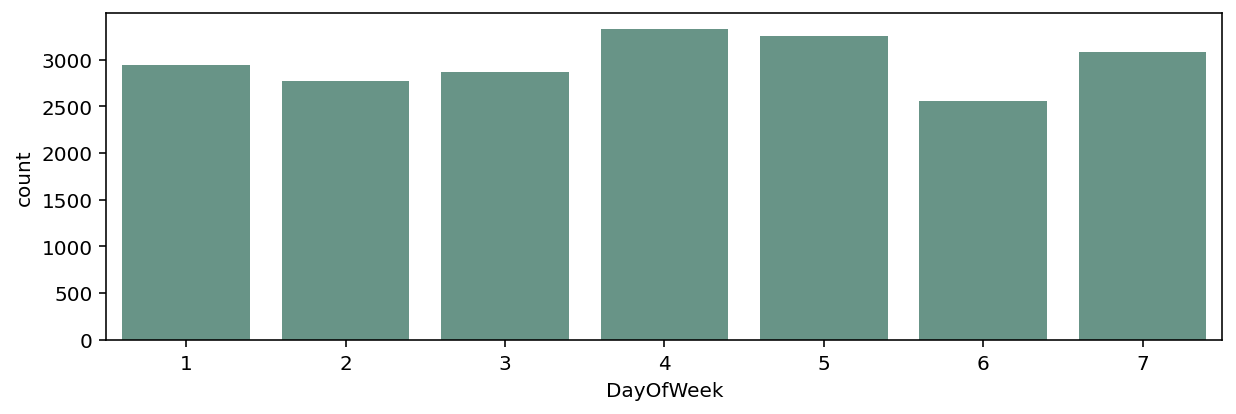

In [14]:
order = [1, 2, 3, 4, 5, 6, 7]
plt.figure(figsize = [10, 3])
sb.countplot(data=flights, x='DayOfWeek', color=color, order=order);

Months with the most of delays are summer months and December, might be due to summer vacations and travels during Christmas time.

Data is evenly distributed between days of week, with about 4% difference between the highest 4 (Thursday) and the lowest 6 (Saturday). It seems weekday or weekend do not affect amount of departure delays. 

Delays are equally distributed by day of month, 31 day outstands because not every month has 31 days in it.

#### Airlines
After looking into delay distribution by dates I'm going to check carrier variable and see how data is distributed there.

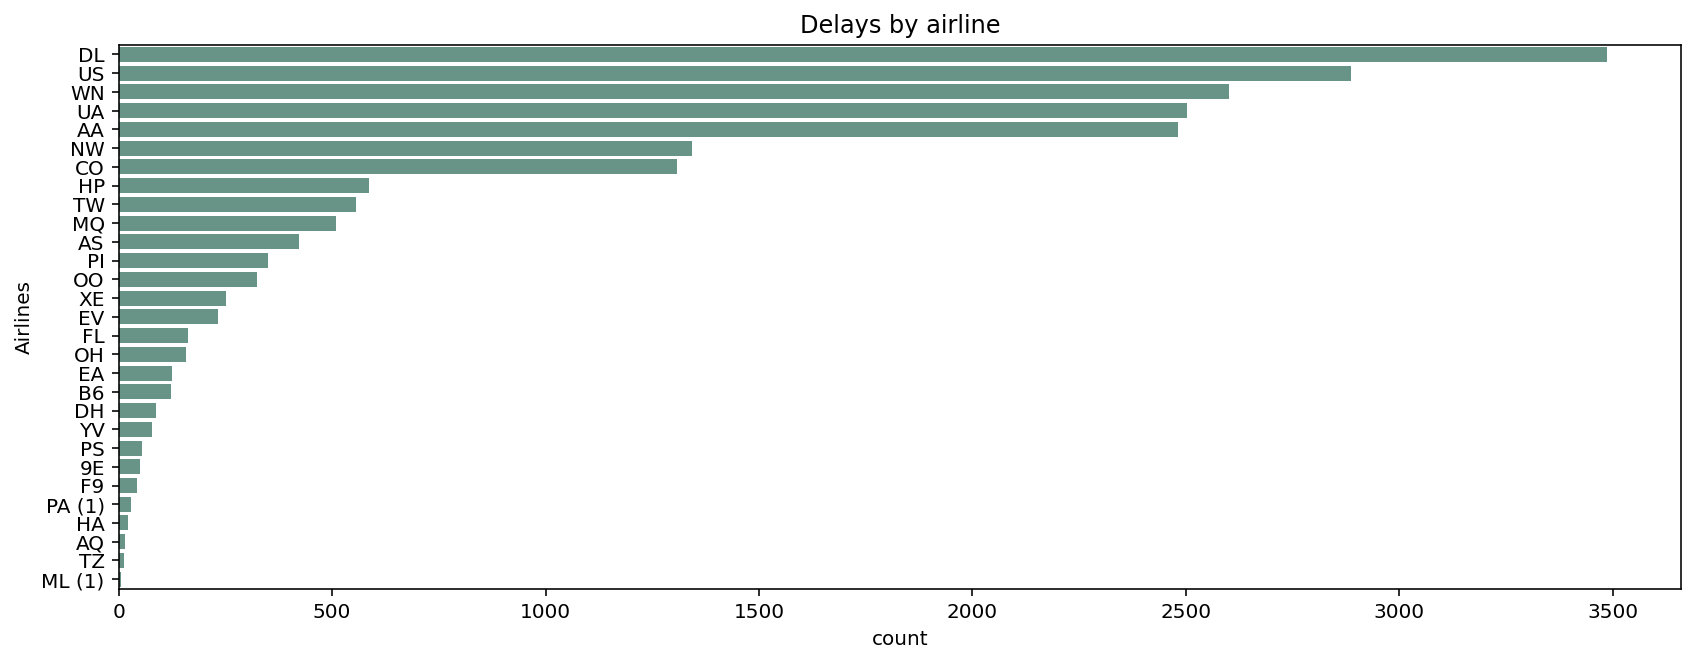

In [15]:
# Plot counts for all 29 airlines in the dataset
plt.figure(figsize = [14, 5])
carriers_order = flights.UniqueCarrier.value_counts().index

sb.countplot(data = flights, y = 'UniqueCarrier',color = color, order = carriers_order);
plt.ylabel('Airlines')
plt.title('Delays by airline');

In [16]:
# Get airlines names from their codes in UniqueCarrier column
df= pd.read_csv('https://raw.githubusercontent.com/jpatokal/openflights/master/data/airlines.dat',
                skiprows=1, names=['AirlineID', 'Name', 'Alias', 'IATA', 'ICAO', 'Callsign', 'Country', 'Active'],
                usecols=['Name', 'IATA', 'Country'])

def map_carrier_codes(codes):
    """ Convert list of carrier codes to carrier names. """
    return list(map(lambda x: df.loc[df.IATA==x].Name.to_string(index=False), codes))

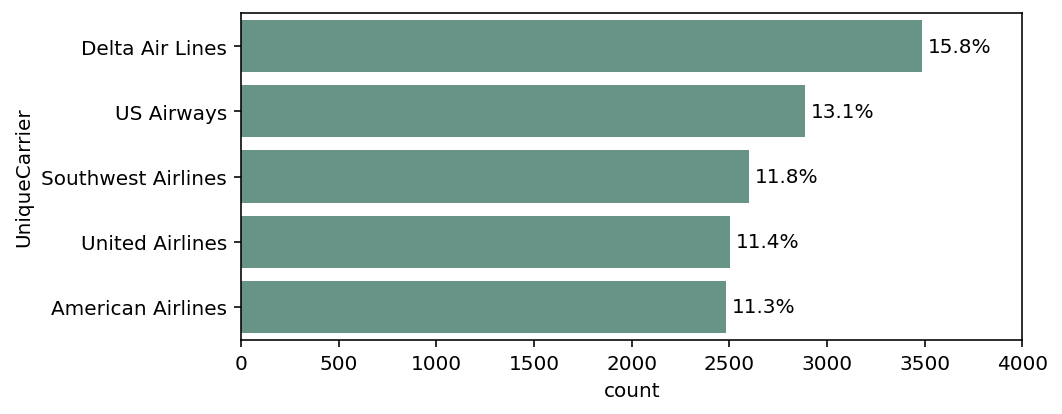

In [17]:
# Plot proportions of delays by top 5 airlines
delay_counts = flights.UniqueCarrier.value_counts()[:5]
carriers_order = delay_counts.index
plt.figure(figsize = [7, 3])

g = sb.countplot(data=flights, y='UniqueCarrier', color=color, order=carriers_order);
g.set_yticklabels(map_carrier_codes(carriers_order))

for i in range (delay_counts.shape[0]):
    count = delay_counts[i]
    pct_string = '{:0.1f}%'.format(100*count/22000)
    plt.text(count+30, i, pct_string, va='center')
    plt.xlim((0,4000))

Distribution of airlines is extremely right skewed and top 5 carriers are responsible for more than 60% of delays, probably because these aircompanies are the largest ones in US. It may be worth to look further into it by ploting against minutes of delay. 

#### Explore airports
There are 268 unique airports in the dataset, I will look at the proportions of top 5.

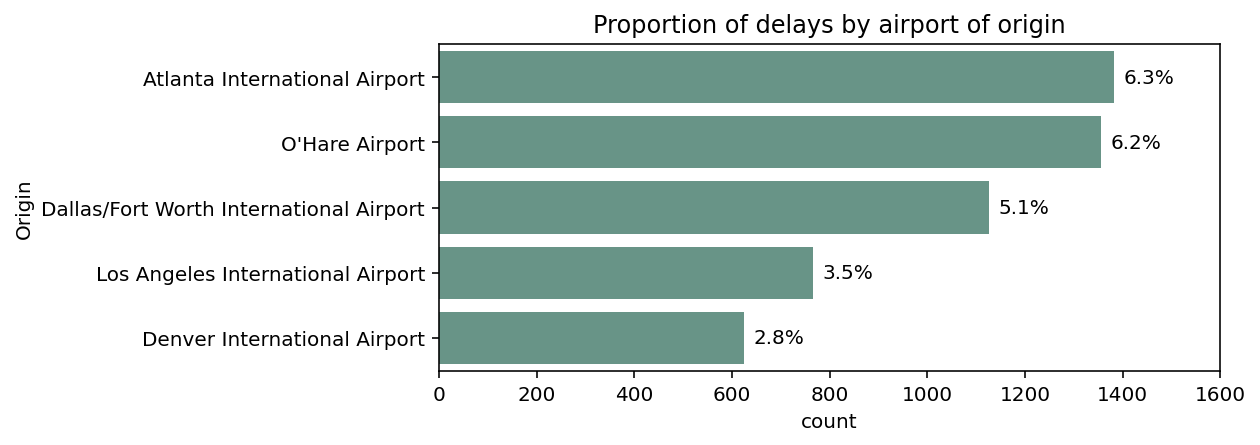

In [18]:
# Airports of origin

airports_o = ['Atlanta International Airport', "O'Hare Airport", 'Dallas/Fort Worth International Airport',
            'Los Angeles International Airport', 'Denver International Airport']

origin_counts = flights.Origin.value_counts()[:5]
origin_order = origin_counts.index

plt.figure(figsize = [7, 3])
g = sb.countplot(data=flights, y='Origin', color=color, order=origin_order);
g.set_yticklabels(airports_o)
plt.title('Proportion of delays by airport of origin')

for i in range (origin_counts.shape[0]):
    count = origin_counts[i]
    pct_string = '{:0.1f}%'.format(100*count/22000)
    plt.text(count+20, i, pct_string, va='center')
    plt.xlim((0,1600))

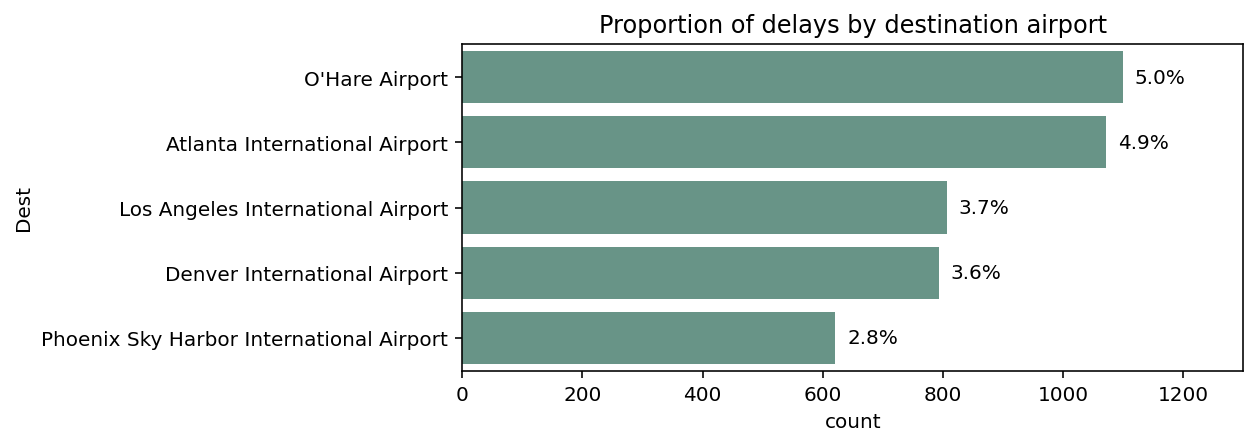

In [19]:
# Destination airports

airports_d = ["O'Hare Airport", 'Atlanta International Airport', 'Los Angeles International Airport',
              'Denver International Airport', 'Phoenix Sky Harbor International Airport']

dest_counts = flights.Dest.value_counts()[:5]
dest_order = dest_counts.index
plt.figure(figsize = [7, 3])
g = sb.countplot(data=flights, y='Dest', color=color, order=dest_order);
g.set_yticklabels(airports_d)
plt.title('Proportion of delays by destination airport')

for i in range (dest_counts.shape[0]):
    count = dest_counts[i]
    pct_string = '{:0.1f}%'.format(100*count/22000)
    plt.text(count+20, i, pct_string, va='center')
    plt.xlim((0,1300))

6 airports from plots above are in the top 10 busiest airports in USA so there is no surprise they have bigger amount of delays. As with airlines it may be worth to plot them against minutes of delay.

#### Explore reasons for delays

There are given 5 reasons for delays and I want to look into each of them for the insights.

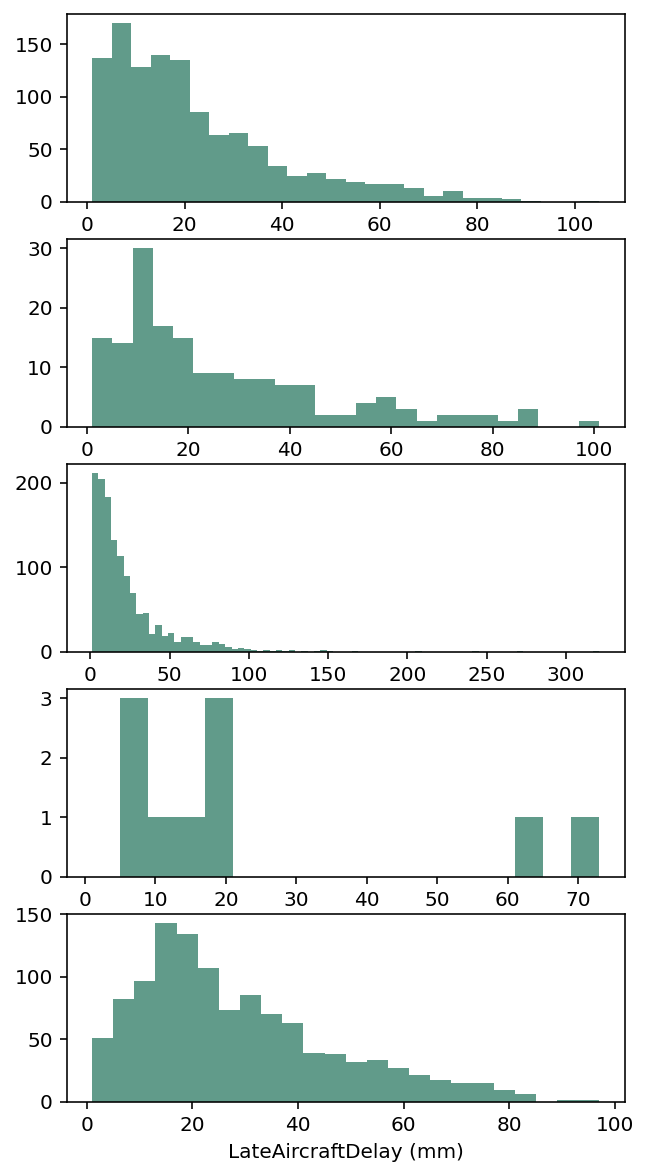

In [20]:
# The airlines report the causes of delays since June 2003, so there is less data about these features

fig, ax = plt.subplots(nrows=5, figsize = [5,10])
binsize = 4
reasons = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
for i in range(len(reasons)):
    var = reasons[i]
    bins = np.arange(1, flights[var].max()+binsize, binsize)
    ax[i].hist(data = flights[flights[var].notnull()], x = var, color=color, bins = bins)
    ax[i].set_xlabel('{} (mm)'.format(var))

plt.show();

In [21]:
# Look closer on SecurityDelay
sc = flights.query('SecurityDelay > 0.0')
sc.shape

(10, 14)

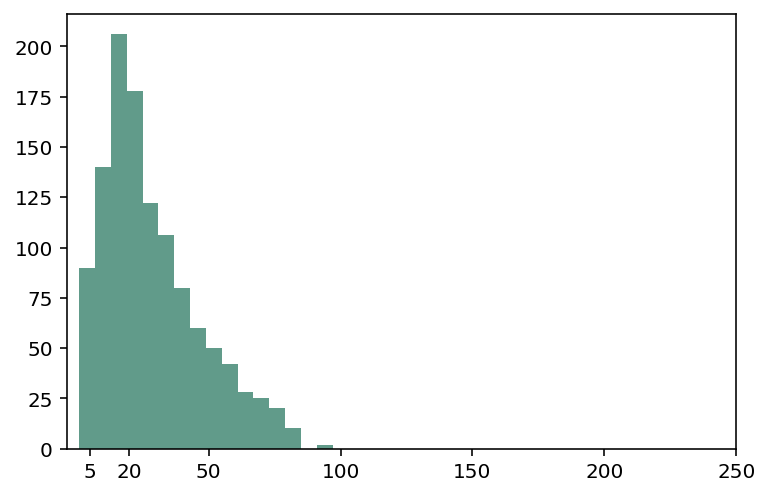

In [22]:
bins = np.arange(1, flights['LateAircraftDelay'].max()+6, 6)
plt.hist(data = flights, x='LateAircraftDelay', color=color, bins=bins)
plt.xticks(ticks=[5, 20, 50, 100, 150, 200, 250]);

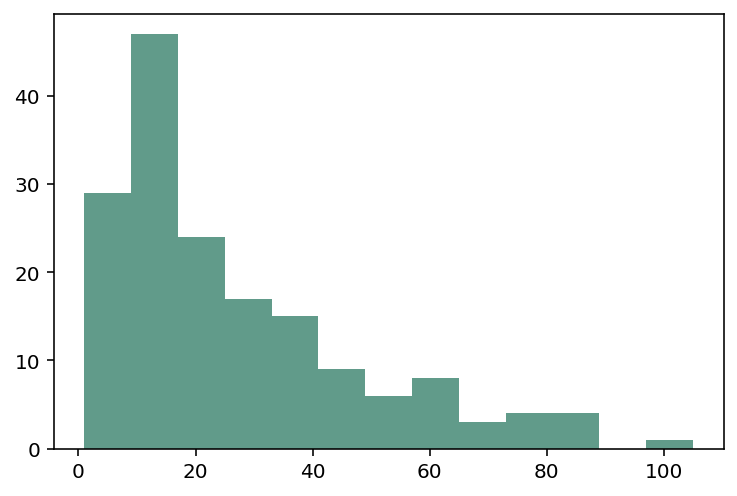

In [23]:
bins = np.arange(1, flights['WeatherDelay'].max()+7, 8)
plt.hist(data = flights, x='WeatherDelay', color=color, bins=bins);

Distributions of CarrierDelay, WeatherDelay, NASDelay, LateAircraftDelay are extremely right skewed with a lot of outliers. WeatherDelay and LateAircraftDelay have their peaks at around 15-20 minutes, whether NASDelay and CarrierDelay have many values below 10 minutes.
Turns out there are only 10 rows in my sample dataset where SecurityDelay is bigger than 0, going to exclude it from further explorations.

### Distribution of the variable of interest

The departure delay distribution looks unimodal, right skewed when plotted on a log-scale, with most delays within 1-60 minutes. It has long tail of outliers, Q3 is at 56.8 minutes and the biggest value is 1433 so I consider dropping rows with outliers.

### Secondary features

Summer and December showed to be the most affected times of the year, probably due to holidays and vacations. SecurityDelay reason turned out to have only 10 values, will not drop these rows because they have other features of interest but exclude them from exploration. WeatherDelay and LateAircraftDelay have more 15-20 minutes delays as opposed to CarrierDelay and CarrierDelay, where delays have their peak at minimum 1 minute and decreasing. 

## Bivariate Exploration

I didn't explore ArrDelay variable itself but I want to add it to bivariate plots to compare correlations between reasons for delays and types of delays. For this purpose I drop outliers in ArrDelay column and plot heatmap and scatter plots on modifided dataset.

In [24]:
# Find and drop outliers
Q1arr = flights.ArrDelay.quantile(0.25)
Q3arr = flights.ArrDelay.quantile(0.75)
IQRarr = Q3 - Q1
margin_arr = IQRarr * 3 + Q3arr
print('Upper margin for outliers: ' + str(margin_arr))
count_arr = flights[flights['ArrDelay'] > margin_arr].Year.count()
print('Amount of outliers: ' + str(count_arr))

flights_mod = flights[flights['ArrDelay'] < margin_arr]
flights_mod.shape

Upper margin for outliers: 87.0
Amount of outliers: 244


(20494, 14)

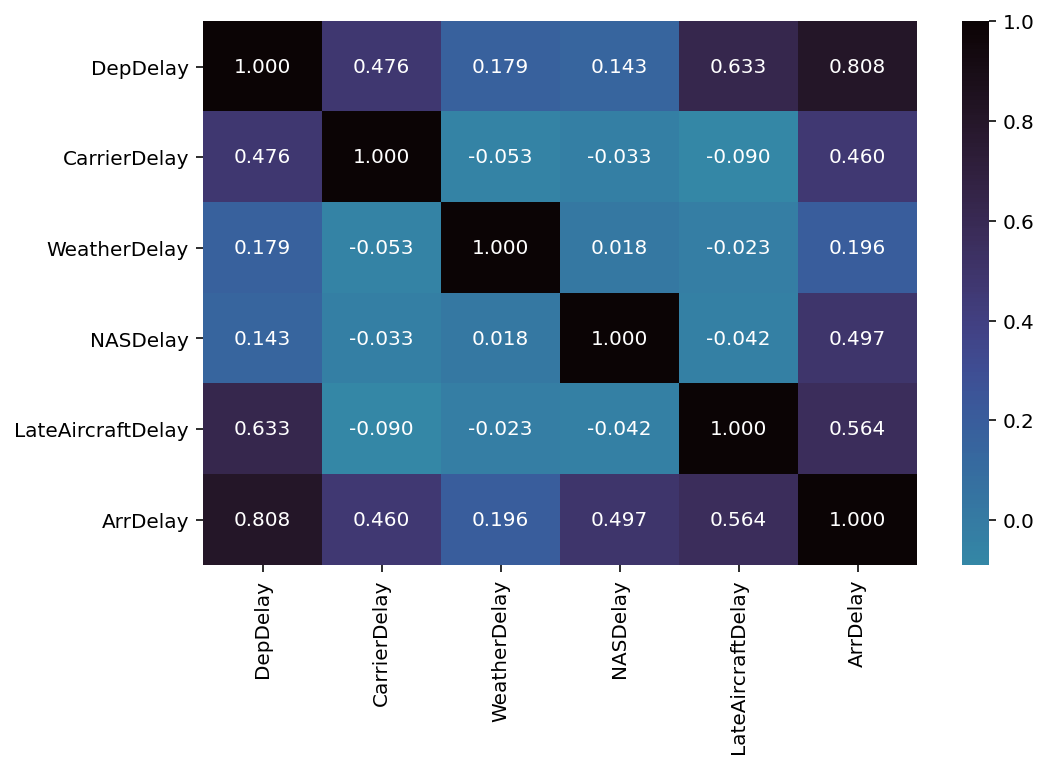

In [25]:
# Plot heatmap of numeric features
numeric_vars = ['DepDelay', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'LateAircraftDelay', 'ArrDelay']

plt.figure(figsize = [8, 5])
sb.heatmap(flights_mod[numeric_vars].corr(), annot = True, fmt = '.3f', cmap = 'mako_r', center = 0)
plt.show()

Expected strong correlation between DepDelay and ArrDelay, also correlations between DepDelay and CarrierDelay/LateAircraftDelay, between ArrDelay and NASDelay.

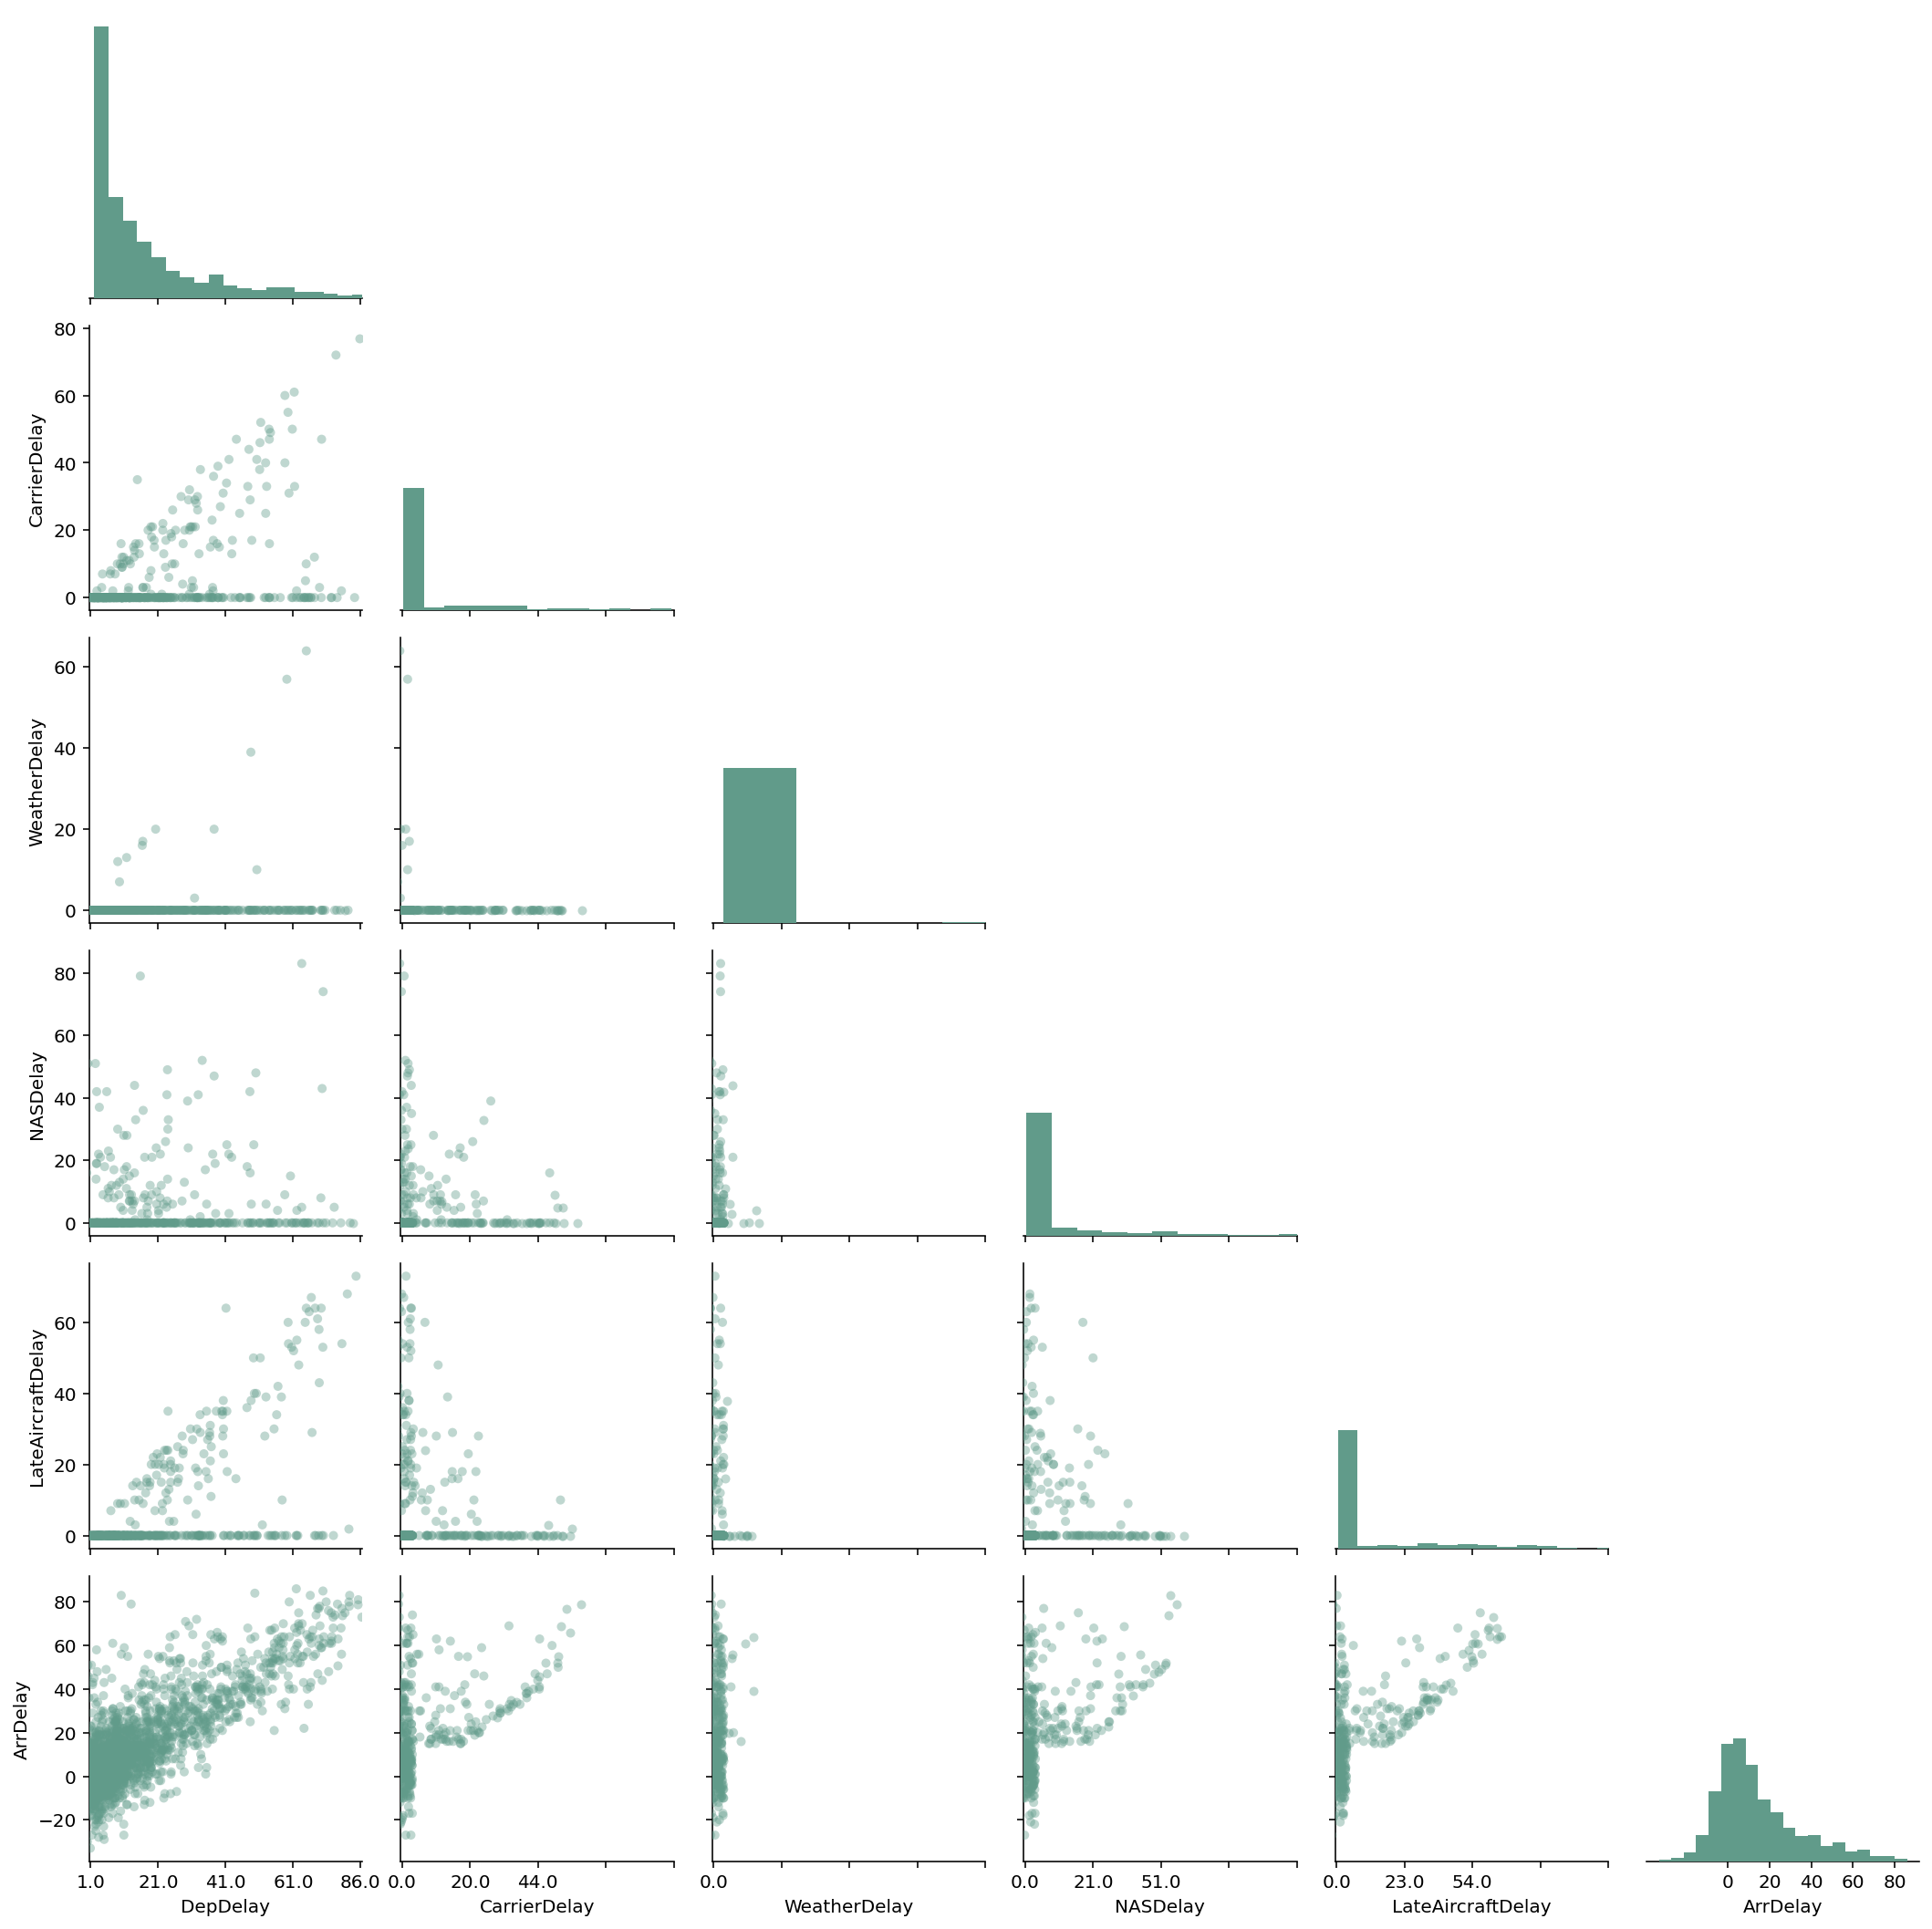

In [26]:
# Plot matrix using 2000 sample
flights_sample = flights_mod.sample(2000, random_state=747)
g = sb.PairGrid(data = flights_sample, vars = numeric_vars, corner=True)
g = g.map_diag(plt.hist, bins = 20, color=color)
g.map_offdiag(sb.stripplot, jitter=3, color=color, alpha = 0.4)
g.set(xticks=np.arange(0,100,20));

As expected, 'CarrierDelay' and 'LateAircraftDelay' have stronger correlation with departure delays, while 'WeatherDelay' and 'NASDelay' have stronger correlation with arrival delays.

#### Delays dynamic over the time

The time variables itself did not present any interesting insides so I try to investigate them in conection with mean delay.

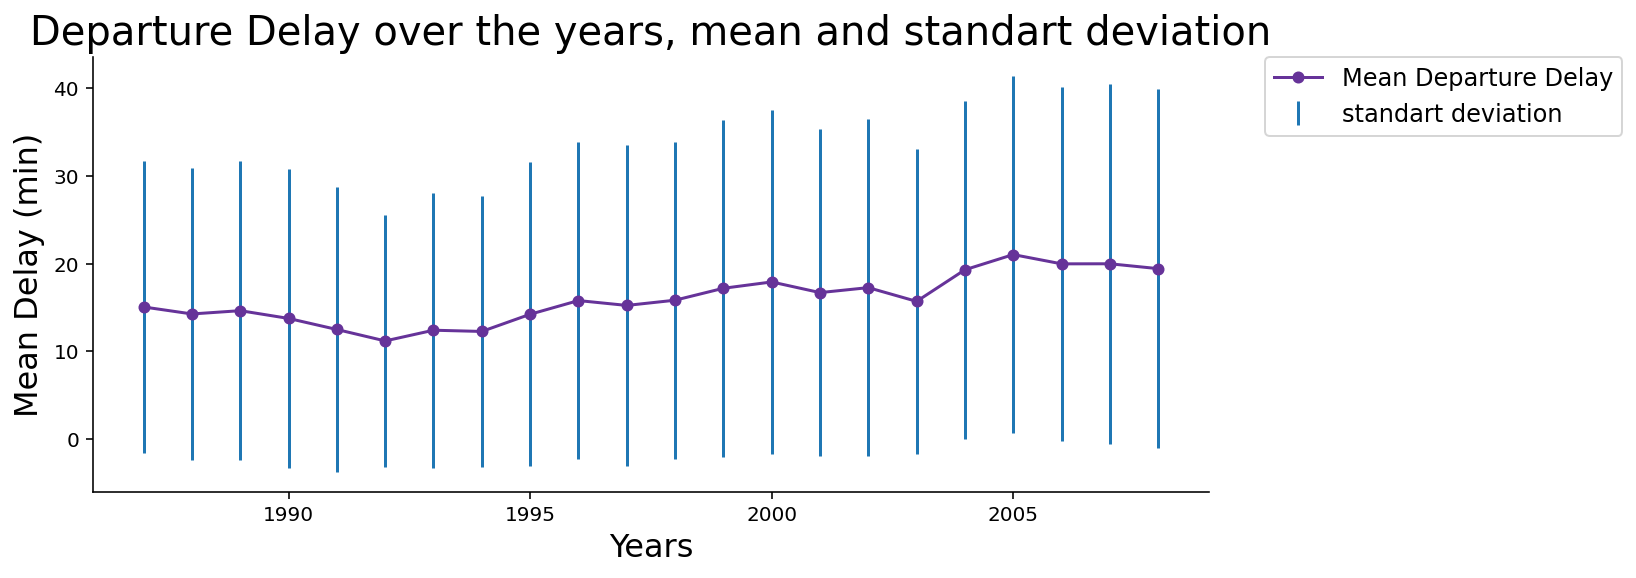

In [27]:
# Calculate mean departure delay for every year and plot it with standart deviation
delay_means = flights.groupby(['Year']).mean().reset_index()

fig, ax = plt.subplots(figsize=(10, 4))
plot_artist, = plt.plot(delay_means['Year'], delay_means['DepDelay'], linestyle='solid', markersize=10, marker='.', color='rebeccapurple')
sb.despine(top=True)

std = flights.groupby(['Year']).std().DepDelay
errorbar_artist = plt.errorbar(delay_means['Year'], delay_means['DepDelay'], yerr=std, linestyle='None')
ax.set_ylabel('Mean Delay (min)', fontsize=16)
ax.set_xlabel('Years', fontsize=16)
ax.set_title("Departure Delay over the years, mean and standart deviation" , fontsize=20)
ax.legend([plot_artist, errorbar_artist], ['Mean Departure Delay', 'standart deviation'],
          bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12);

An average departure delay and its std are slowly increasing, probably due to increasing amount of flights and their influence on each other.

#### Delay destribution in the busiest airports
Do the top 5 busiest airports have any peculiarities in their distribution?

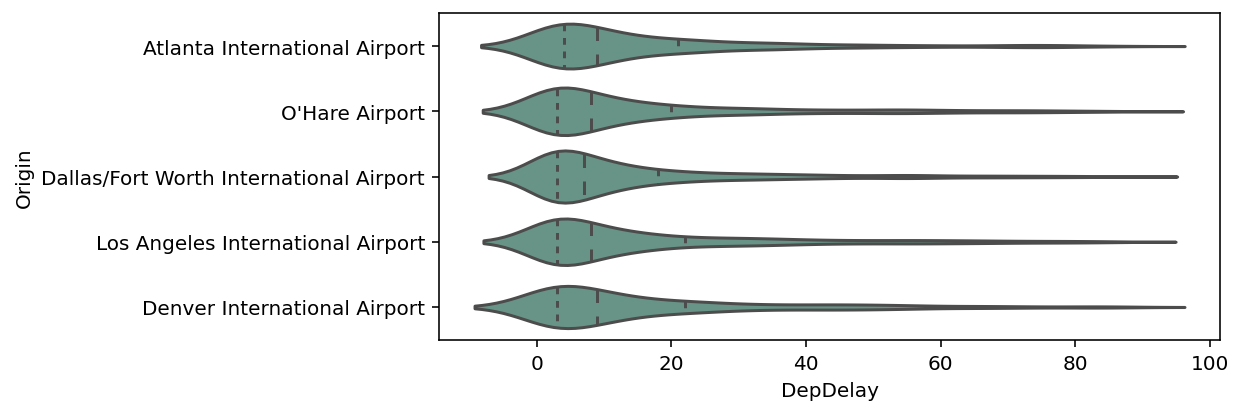

In [28]:
# In airports of origin

airports_o = ['Atlanta International Airport', "O'Hare Airport", 'Dallas/Fort Worth International Airport',
            'Los Angeles International Airport', 'Denver International Airport']
origin_order = flights.Origin.value_counts()[:5].index
top_origin = flights[flights['Origin'].isin(origin_order)]

plt.figure(figsize = [7, 3])
g = sb.violinplot(data=top_origin, y='Origin', x='DepDelay', inner = 'quartile', color = color)
g.set_yticklabels(airports_o);

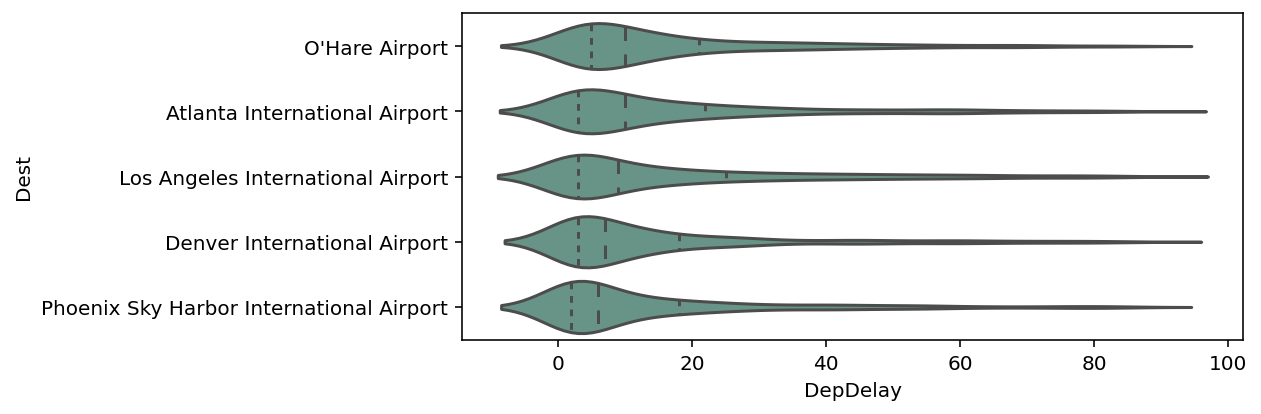

In [29]:
# Destination airports

airports_d = ["O'Hare Airport", 'Atlanta International Airport', 'Los Angeles International Airport',
              'Denver International Airport', 'Phoenix Sky Harbor International Airport']


dest_order = flights.Dest.value_counts()[:5].index
top_dest = flights[flights['Dest'].isin(dest_order)]

plt.figure(figsize = [7, 3])
g = sb.violinplot(data=top_dest, y='Dest', x='DepDelay', inner = 'quartile', color = color)
g.set_yticklabels(airports_d)
plt.title('');


Departure delays have similar distribution in top 6 busiest airports showing a lot outliers.

### Observed relationships of the feature of interest with other features

A time plot shows increase in mean delay and its std over the years despite the same amount of data sampled for each year. This may probably mean that flights frequency increases as industry develops and airports become more busy.  

### Relationships between the other features

Delay reasons correlate differently with delays on departure vs. on arrival. 'CarrierDelay' and 'LateAircraftDelay' occur in airport of origin and therefore have stronger correlation with departure delays, while 'WeatherDelay' and 'NASDelay' have stronger correlation with arrival delays.

## Multivariate Exploration

#### How did carriers performed over the years?

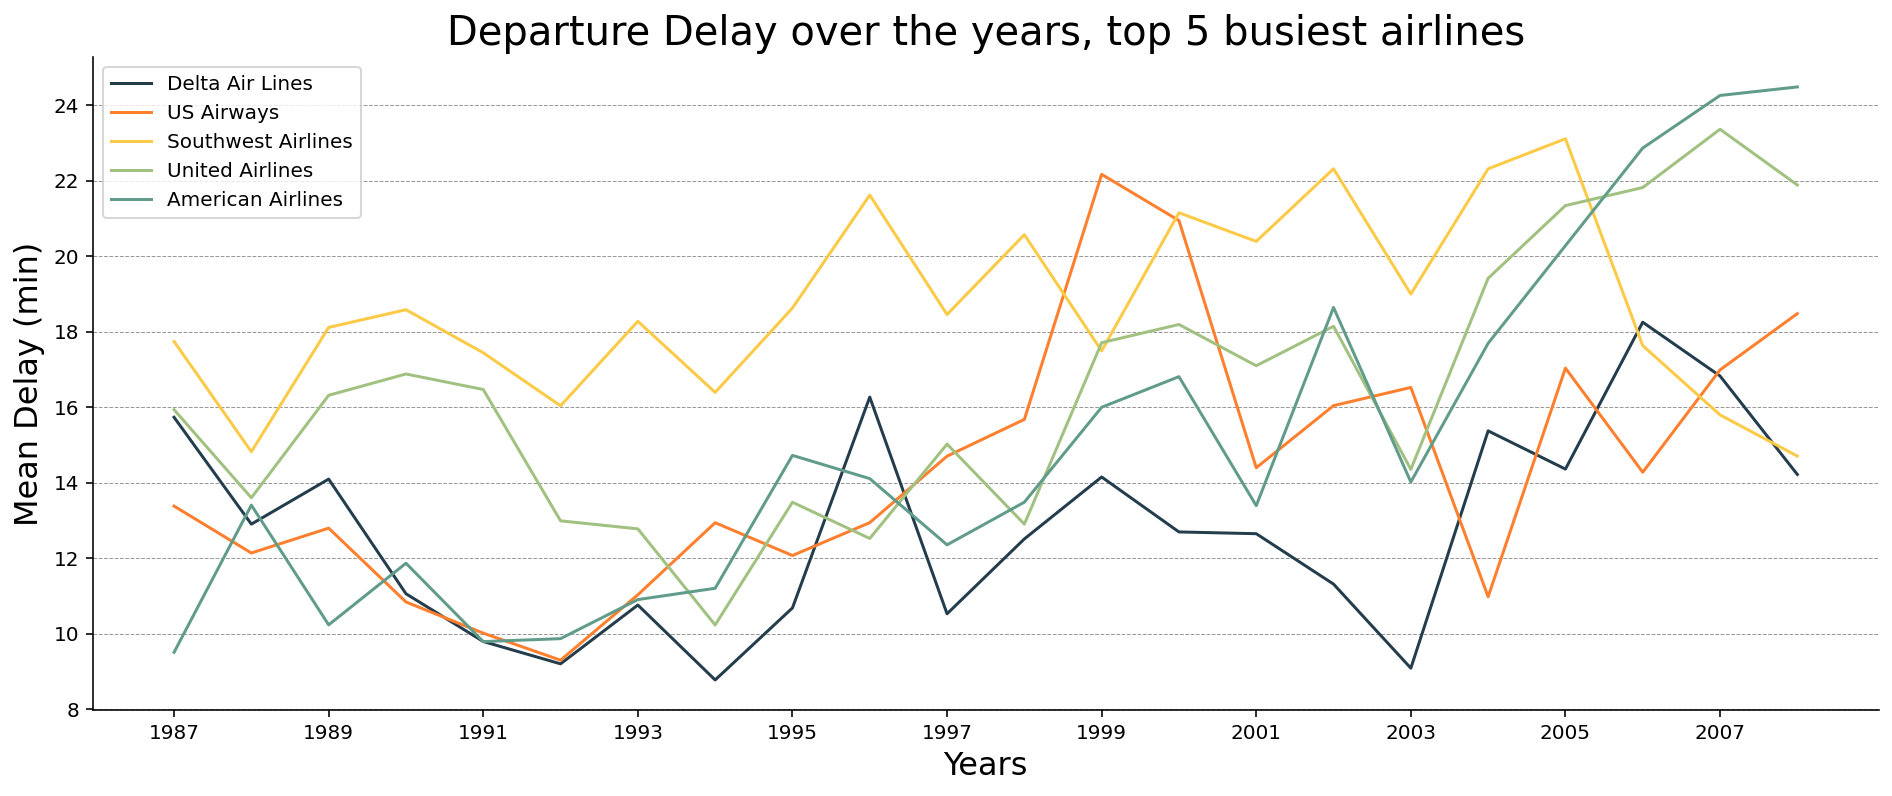

In [30]:
# Plot 5 timelines for top 5 carriers with the most of departure delays
airline_names = {'DL': 'Delta Air Lines', 'US': 'US Airways', 'WN': 'Southwest Airlines', 'UA': 'United Airlines',
                 'AA': 'American Airlines'}

top5_airlines = [{'airline':'DL', 'color':'#233d4d'},
                 {'airline':'US', 'color':'#fe7f2d'},
                 {'airline':'WN', 'color':'#fcca46'},
                 {'airline':'UA', 'color':'#a1c181'},
                 {'airline':'AA', 'color':'#619b8a'}]

def plot_delay(params):
    """ Plot carrier delay using given code and color, and return plot artist. """
    means = flights[flights['UniqueCarrier'] == params['airline']].groupby(['Year']).mean().reset_index() 
    artist, = plt.plot(means['Year'], means['DepDelay'], linestyle='solid', color=params['color'])
    return artist

fig, ax = plt.subplots(figsize=(16, 6))

delay_handles = list(map(plot_delay, top5_airlines))
delay_labels = list(map(lambda params: airline_names[params['airline']], top5_airlines))

plt.legend(delay_handles, delay_labels)
plt.grid(axis='y', color='#999999', linestyle = '--', linewidth = 0.5)
sb.despine(top=True)
ax.set_ylabel('Mean Delay (min)', fontsize=16)
ax.set_xlabel('Years', fontsize=16)
plt.xticks(np.arange(1987, 2009, 2))
ax.set_title("Departure Delay over the years, top 5 busiest airlines" , fontsize=20);

On the timeline plot Southwest Airlines had interesting change of mean delay: first 10 years of observation it was higher that others then in 2005 we see constant decrease. Other 4 carriers were slowly increasing their departure delay means with a sharp increase of mean delay at 2003, probably because the new report system was implemented and data became more accurate.
#### How do the reasons for delays distributed over months and is there any difference among their distributions?

In [31]:
# Prepare dataset to plot reasons of delay as categories

month_delays = flights.groupby('Month').mean().reset_index()
tdrop = ['Year', 'DayofMonth', 'DayOfWeek', 'ArrDelay', 'SecurityDelay']
month_delays = month_delays.drop(tdrop, axis=1)
month_delays['Month'] = month_delays['Month'].astype(str).str.zfill(2)

month_tidy = month_delays.melt(id_vars='Month').sort_values('Month')

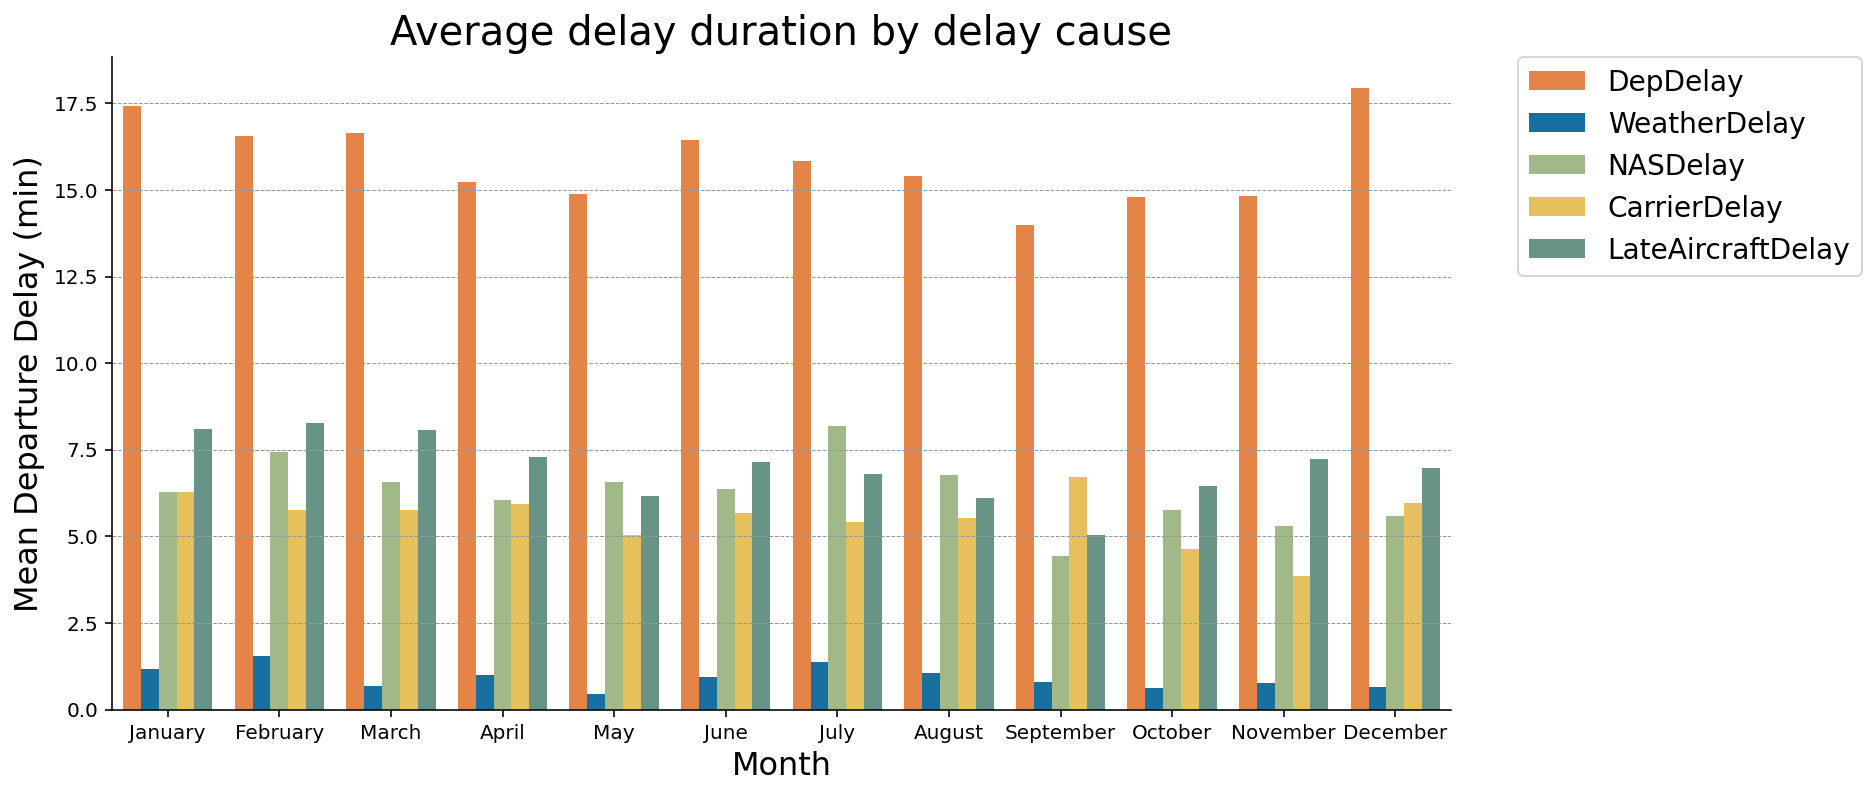

In [32]:
# Plot mean delays by the reasons and DepDelay to compare

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
del_colors = ['#fe7f2d', '#0077b6', '#a1c181', '#fcca46', '#619b8a']

plt.figure(figsize = [12, 6])
ax = sb.barplot(data = month_tidy, x = 'Month', y = 'value', hue = 'variable', palette=del_colors)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=14)
ax.set_xticklabels(months)
ax.set_ylabel('Mean Departure Delay (min)', fontsize=16)
ax.set_title('Average delay duration by delay cause', fontsize=20)
ax.set_xlabel('Month', fontsize=16)
plt.grid(axis='y', color='#999999', linestyle = '--', linewidth = 0.5)
sb.despine();

### The relationships observed during multivariate exploration

I expected more drastic differences between reasons and their distribution over the months. Weather has not so huge impact on delay average, LateAircraftDelay tends to be longer at the beginning of the year. CarrierDelay shows that avialines perform evenly with small decrease in November.

### Other interactions between features

Interestingly, Southwest Airlines had the highest mean delay over the first 10 years of observation, then in 2005 we see strong decrease. Now I would like to look at their data after 2008 to check if they preserved that tendency. Other 4 carriers were slowly increasing their departure delay means and I wonder if they were able to change the trend or they were highly affected by other factors. There is a sharp increase of mean delay at 2003, probably because the new report system was implemented and data became more accurate.

## Conclusions

For this project, I used flight data from 1987 to 2008 from US to analyse delay, in particulary departure delay. I selected few features to look deeper into their correlations with delays. The main feature of interest showed a wide range of values from 0 to 1433 but the most of flights were delayed not more than on 1 hour. It was slowly increasing over the years with a bump at 2003 when the new report system was implemented. 

While looking into carriers I found out that 5 of 29 carriers are responsible for more than 60% of delays but their mean departure delays are relativly low. Southwest Airlines had interesting change of mean delay: first 10 years of observation it was higher that others then in 2005 we see constant decrease. Now I would like to look at their data after 2008 to check if they preserved that tendency. Other 4 carriers were slowly increasing their departure delay means and I wonder if they were able to change the trend or they were highly affected by other factors. There is a sharp increase of mean delay at 2003, probably because the new report system was implemented and data became more accurate.

As to reported reasons for delays, 'CarrierDelay' and 'LateAircraftDelay' have stronger correlation with departure delays, while 'WeatherDelay' and 'NASDelay' have stronger correlation with arrival delays. Weather shows to have not so huge impact on delay average, LateAircraftDelay tends to be longer at the beginning of the year and CarrierDelay shows that avialines perform evenly with small decrease in November.

6 airports that have most of the delays – Atlanta International Airport, O'Hare Airport, Dallas/Fort Worth International Airport, Los Angeles International Airport, Denver International Airport – are in top 10 busiest airports in USA so there is no surprise they have a bigger part of delays.